# Recurrent Neural Networks: RNN, GRU, and LSTM

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hamidmatiny/ML_Portfolio/blob/main/04_Advanced%20deep%20learning/RNN_GRU_LSTM_Tutorial.ipynb)

## Overview

This notebook explores **Recurrent Neural Networks (RNNs)** and their advanced variants: **GRU (Gated Recurrent Unit)** and **LSTM (Long Short-Term Memory)**. We'll implement all three architectures using PyTorch and demonstrate their effectiveness on sequential data.

### What You'll Learn:
- Understanding sequential data and the vanishing gradient problem
- RNN architecture and limitations
- GRU: Solving vanishing gradients with gating mechanisms
- LSTM: Advanced memory management with forget, input, and output gates
- Practical implementation on MNIST digit classification
- Performance comparison between architectures

### Key Concepts:
- **Sequential Processing**: Processing data one step at a time
- **Hidden States**: Memory that carries information across time steps
- **Gating Mechanisms**: Controlling information flow in neural networks
- **Vanishing Gradients**: Why simple RNNs struggle with long sequences

## 1. Understanding Sequential Data

Traditional neural networks process fixed-size inputs independently. But many real-world problems involve **sequential data** where:
- Order matters (time series, text, speech)
- Variable-length inputs (sentences, audio clips)
- Dependencies exist between elements

**Examples:**
- Text: "The cat sat on the mat" vs "Mat the on sat cat the"
- Time series: Stock prices, weather data
- Speech: Audio waveforms
- Images as sequences: Treating MNIST digits as 28 sequences of 28 pixels

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


## 2. Data Preparation: MNIST as Sequential Data

We'll treat MNIST digits (28×28 images) as sequences of 28 time steps, each with 28 features (pixel values). This demonstrates how RNNs can process spatial data sequentially.

In [2]:
# Hyperparameters
input_size = 28      # Number of features per time step (pixels per row)
sequence_length = 28 # Number of time steps (rows in image)
hidden_size = 128    # Size of hidden state
num_layers = 2       # Number of RNN layers
num_classes = 10     # Number of output classes (digits 0-9)
batch_size = 100
learning_rate = 0.001
num_epochs = 2

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    transform=transforms.ToTensor(),  
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    transform=transforms.ToTensor()
)

# Data loaders
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.84MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 737kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.07MB/s]

Training samples: 60000
Test samples: 10000


### Visualizing Sequential Processing

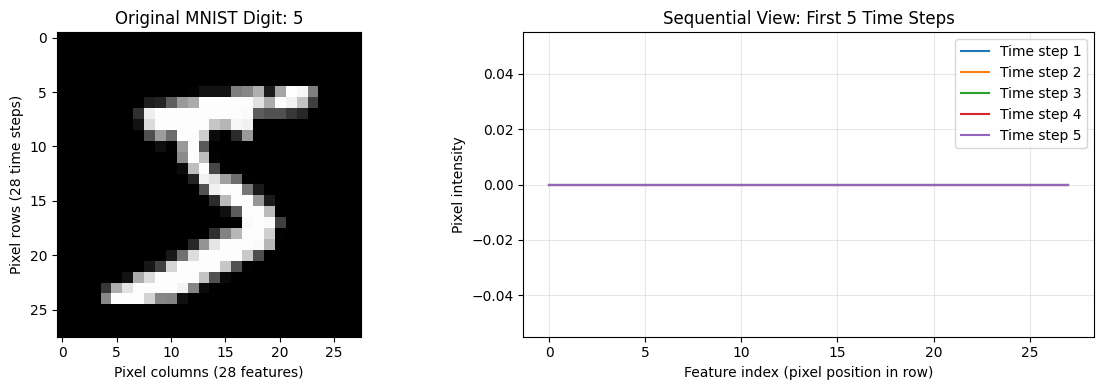

Image shape: torch.Size([28, 28])
Sequence length: 28, Input size: 28


In [3]:
# Visualize how we treat images as sequences
sample_image, label = train_dataset[0]
sample_image = sample_image.squeeze()  # Remove channel dimension

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Original image
ax1.imshow(sample_image, cmap='gray')
ax1.set_title(f'Original MNIST Digit: {label}')
ax1.set_xlabel('Pixel columns (28 features)')
ax1.set_ylabel('Pixel rows (28 time steps)')

# Sequential view - show first few rows as time steps
time_steps_to_show = 5
for i in range(time_steps_to_show):
    ax2.plot(sample_image[i], label=f'Time step {i+1}')
ax2.set_title('Sequential View: First 5 Time Steps')
ax2.set_xlabel('Feature index (pixel position in row)')
ax2.set_ylabel('Pixel intensity')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Image shape: {sample_image.shape}")
print(f"Sequence length: {sequence_length}, Input size: {input_size}")

## 3. Vanilla RNN Architecture

### The RNN Formula
At each time step t:
```
h_t = tanh(W_hh * h_{t-1} + W_xh * x_t + b_h)
```

Where:
- `h_t`: Hidden state at time t
- `x_t`: Input at time t
- `W_hh`: Hidden-to-hidden weight matrix
- `W_xh`: Input-to-hidden weight matrix
- `b_h`: Hidden bias

### Problems with Vanilla RNN:
1. **Vanishing Gradients**: Gradients diminish exponentially through time
2. **Short Memory**: Difficulty learning long-term dependencies
3. **Exploding Gradients**: Gradients can grow exponentially (less common)

In [4]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(VanillaRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # RNN layer
        self.rnn = nn.RNN(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True  # Input shape: (batch, seq, features)
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate RNN
        # out: (batch_size, seq_length, hidden_size)
        out, _ = self.rnn(x, h0)
        
        # Use output from last time step
        out = out[:, -1, :]  # (batch_size, hidden_size)
        
        # Final classification
        out = self.fc(out)   # (batch_size, num_classes)
        return out

# Create model
rnn_model = VanillaRNN(input_size, hidden_size, num_layers, num_classes).to(device)
print(f"RNN Model Parameters: {sum(p.numel() for p in rnn_model.parameters()):,}")

RNN Model Parameters: 54,538


## 4. GRU (Gated Recurrent Unit)

GRU addresses vanishing gradients using **gating mechanisms**:

### GRU Gates:
1. **Reset Gate (r_t)**: Controls how much past information to forget
2. **Update Gate (z_t)**: Controls how much new information to store

### GRU Equations:
```
r_t = σ(W_r * [h_{t-1}, x_t])
z_t = σ(W_z * [h_{t-1}, x_t])
h̃_t = tanh(W_h * [r_t ⊙ h_{t-1}, x_t])
h_t = (1 - z_t) ⊙ h_{t-1} + z_t ⊙ h̃_t
```

### Advantages:
- Fewer parameters than LSTM
- Better gradient flow
- Faster training

In [5]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRUModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # GRU layer
        self.gru = nn.GRU(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate GRU
        out, _ = self.gru(x, h0)
        
        # Use output from last time step
        out = out[:, -1, :]
        
        # Final classification
        out = self.fc(out)
        return out

# Create model
gru_model = GRUModel(input_size, hidden_size, num_layers, num_classes).to(device)
print(f"GRU Model Parameters: {sum(p.numel() for p in gru_model.parameters()):,}")

GRU Model Parameters: 161,034


## 5. LSTM (Long Short-Term Memory)

LSTM is the most sophisticated RNN variant with **three gates** and a **cell state**:

### LSTM Components:
1. **Cell State (C_t)**: Long-term memory highway
2. **Hidden State (h_t)**: Short-term memory/output
3. **Forget Gate (f_t)**: What to remove from cell state
4. **Input Gate (i_t)**: What new information to store
5. **Output Gate (o_t)**: What parts of cell state to output

### LSTM Equations:
```
f_t = σ(W_f * [h_{t-1}, x_t] + b_f)  # Forget gate
i_t = σ(W_i * [h_{t-1}, x_t] + b_i)  # Input gate
C̃_t = tanh(W_C * [h_{t-1}, x_t] + b_C)  # Candidate values
C_t = f_t ⊙ C_{t-1} + i_t ⊙ C̃_t     # Cell state
o_t = σ(W_o * [h_{t-1}, x_t] + b_o)  # Output gate
h_t = o_t ⊙ tanh(C_t)                # Hidden state
```

### Advantages:
- Excellent long-term memory
- Solves vanishing gradient problem
- Most widely used for complex sequences

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Use output from last time step
        out = out[:, -1, :]
        
        # Final classification
        out = self.fc(out)
        return out

# Create model
lstm_model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
print(f"LSTM Model Parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")

LSTM Model Parameters: 214,282


## 6. Training Function

We'll create a unified training function to compare all three architectures.

In [7]:
def train_model(model, model_name, num_epochs=2):
    """
    Train a recurrent model and return training history.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    train_losses = []
    train_accuracies = []
    
    n_total_steps = len(train_loader)
    
    print(f"\n=== Training {model_name} ===")
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(train_loader):
            # Reshape images: [batch, 1, 28, 28] -> [batch, 28, 28]
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], '
                      f'Loss: {loss.item():.4f}')
        
        # Epoch statistics
        avg_loss = epoch_loss / len(train_loader)
        accuracy = 100.0 * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, '
              f'Accuracy: {accuracy:.2f}%')
    
    return train_losses, train_accuracies

def test_model(model, model_name):
    """
    Test a trained model and return accuracy.
    """
    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        
        for images, labels in test_loader:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100.0 * correct / total
        print(f'{model_name} Test Accuracy: {accuracy:.2f}%')
        return accuracy

## 7. Training and Comparison

Let's train all three models and compare their performance.

In [8]:
# Train RNN
rnn_losses, rnn_accuracies = train_model(rnn_model, "Vanilla RNN", num_epochs)
rnn_test_acc = test_model(rnn_model, "Vanilla RNN")


=== Training Vanilla RNN ===
Epoch [1/2], Step [100/600], Loss: 0.8782
Epoch [1/2], Step [200/600], Loss: 0.5875
Epoch [1/2], Step [300/600], Loss: 0.4328
Epoch [1/2], Step [400/600], Loss: 0.5015
Epoch [1/2], Step [500/600], Loss: 0.2570
Epoch [1/2], Step [600/600], Loss: 0.4759
Epoch [1/2] - Loss: 0.6516, Accuracy: 78.53%
Epoch [2/2], Step [100/600], Loss: 0.4125
Epoch [2/2], Step [200/600], Loss: 0.1137
Epoch [2/2], Step [300/600], Loss: 0.2160
Epoch [2/2], Step [400/600], Loss: 0.2102
Epoch [2/2], Step [500/600], Loss: 0.2294
Epoch [2/2], Step [600/600], Loss: 0.2725
Epoch [2/2] - Loss: 0.2661, Accuracy: 92.30%
Vanilla RNN Test Accuracy: 93.87%


In [9]:
# Train GRU
gru_losses, gru_accuracies = train_model(gru_model, "GRU", num_epochs)
gru_test_acc = test_model(gru_model, "GRU")


=== Training GRU ===
Epoch [1/2], Step [100/600], Loss: 0.7092
Epoch [1/2], Step [200/600], Loss: 0.3287
Epoch [1/2], Step [300/600], Loss: 0.3519
Epoch [1/2], Step [400/600], Loss: 0.1781
Epoch [1/2], Step [500/600], Loss: 0.0911
Epoch [1/2], Step [600/600], Loss: 0.1605
Epoch [1/2] - Loss: 0.4743, Accuracy: 84.14%
Epoch [2/2], Step [100/600], Loss: 0.0835
Epoch [2/2], Step [200/600], Loss: 0.1382
Epoch [2/2], Step [300/600], Loss: 0.1285
Epoch [2/2], Step [400/600], Loss: 0.0359
Epoch [2/2], Step [500/600], Loss: 0.0464
Epoch [2/2], Step [600/600], Loss: 0.0588
Epoch [2/2] - Loss: 0.1114, Accuracy: 96.71%
GRU Test Accuracy: 96.64%


In [10]:
# Train LSTM
lstm_losses, lstm_accuracies = train_model(lstm_model, "LSTM", num_epochs)
lstm_test_acc = test_model(lstm_model, "LSTM")


=== Training LSTM ===
Epoch [1/2], Step [100/600], Loss: 0.7153
Epoch [1/2], Step [200/600], Loss: 0.3554
Epoch [1/2], Step [300/600], Loss: 0.2747
Epoch [1/2], Step [400/600], Loss: 0.3691
Epoch [1/2], Step [500/600], Loss: 0.2337
Epoch [1/2], Step [600/600], Loss: 0.2199
Epoch [1/2] - Loss: 0.4997, Accuracy: 83.44%
Epoch [2/2], Step [100/600], Loss: 0.1478
Epoch [2/2], Step [200/600], Loss: 0.1155
Epoch [2/2], Step [300/600], Loss: 0.2083
Epoch [2/2], Step [400/600], Loss: 0.0596
Epoch [2/2], Step [500/600], Loss: 0.0679
Epoch [2/2], Step [600/600], Loss: 0.1593
Epoch [2/2] - Loss: 0.1248, Accuracy: 96.25%
LSTM Test Accuracy: 96.79%


## 8. Performance Analysis and Visualization

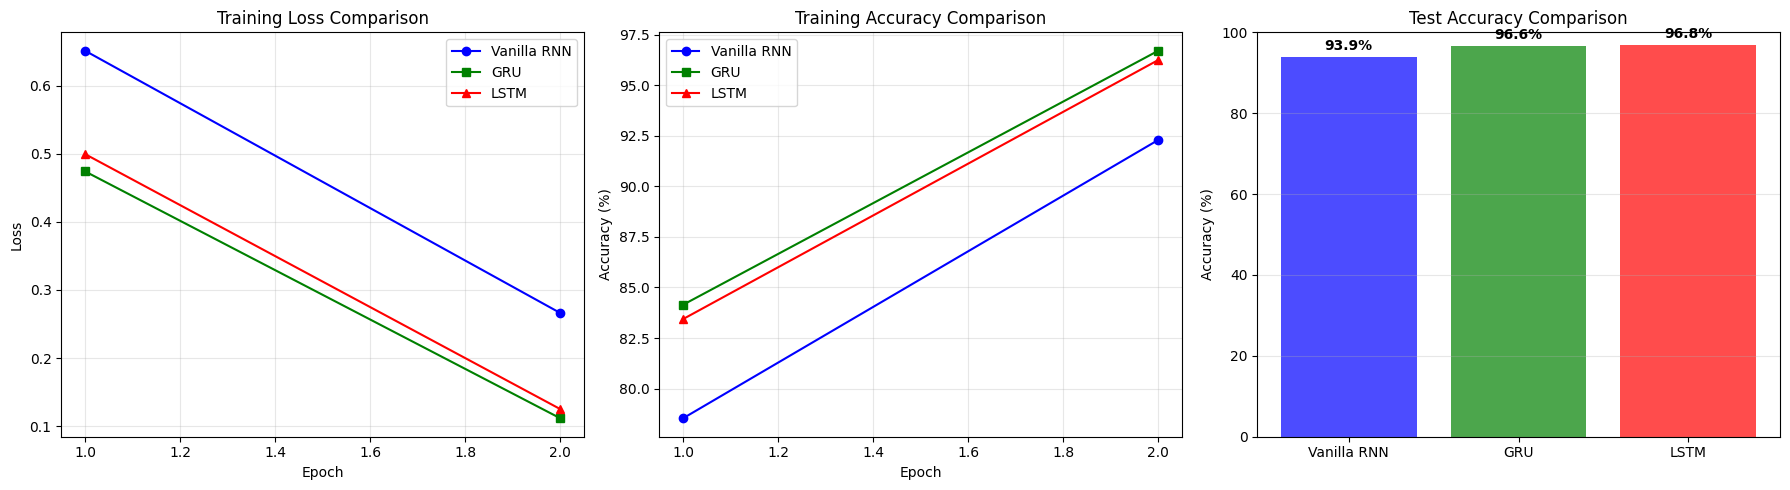

In [11]:
# Plot training curves
epochs = range(1, num_epochs + 1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Training Loss
ax1.plot(epochs, rnn_losses, 'b-', label='Vanilla RNN', marker='o')
ax1.plot(epochs, gru_losses, 'g-', label='GRU', marker='s')
ax1.plot(epochs, lstm_losses, 'r-', label='LSTM', marker='^')
ax1.set_title('Training Loss Comparison')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Training Accuracy
ax2.plot(epochs, rnn_accuracies, 'b-', label='Vanilla RNN', marker='o')
ax2.plot(epochs, gru_accuracies, 'g-', label='GRU', marker='s')
ax2.plot(epochs, lstm_accuracies, 'r-', label='LSTM', marker='^')
ax2.set_title('Training Accuracy Comparison')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Test Accuracy Comparison
models = ['Vanilla RNN', 'GRU', 'LSTM']
test_accuracies = [rnn_test_acc, gru_test_acc, lstm_test_acc]
colors = ['blue', 'green', 'red']

bars = ax3.bar(models, test_accuracies, color=colors, alpha=0.7)
ax3.set_title('Test Accuracy Comparison')
ax3.set_ylabel('Accuracy (%)')
ax3.set_ylim(0, 100)

# Add value labels on bars
for bar, acc in zip(bars, test_accuracies):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 9. Model Complexity Analysis


=== Model Complexity Comparison ===
Vanilla RNN Parameters: 54,538
GRU Parameters: 161,034
LSTM Parameters: 214,282

GRU vs RNN: 3.0x more parameters
LSTM vs RNN: 3.9x more parameters
LSTM vs GRU: 1.3x more parameters


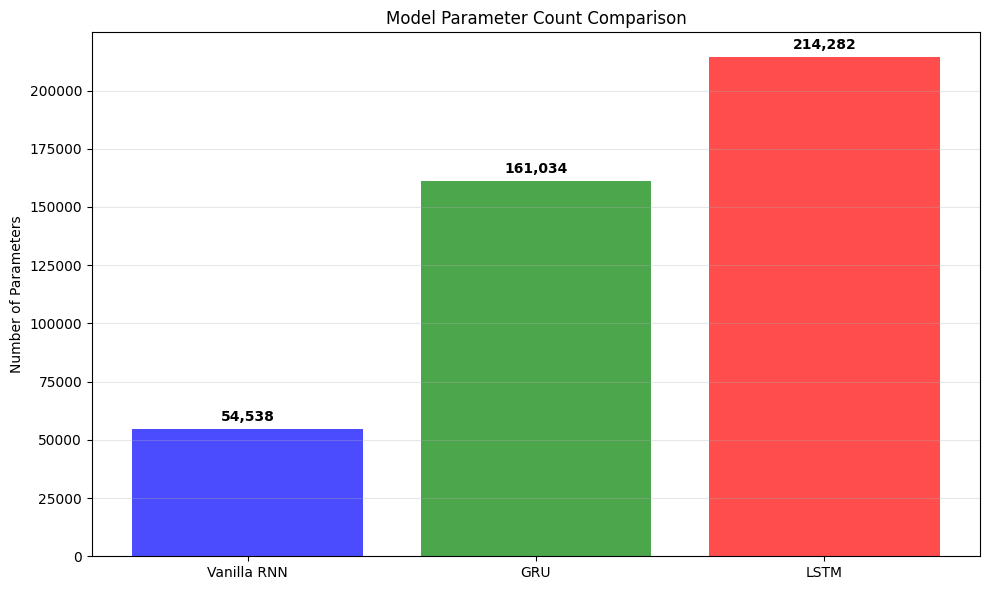

In [12]:
# Compare model complexities
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

rnn_params = count_parameters(rnn_model)
gru_params = count_parameters(gru_model)
lstm_params = count_parameters(lstm_model)

print("\n=== Model Complexity Comparison ===")
print(f"Vanilla RNN Parameters: {rnn_params:,}")
print(f"GRU Parameters: {gru_params:,}")
print(f"LSTM Parameters: {lstm_params:,}")

print(f"\nGRU vs RNN: {gru_params/rnn_params:.1f}x more parameters")
print(f"LSTM vs RNN: {lstm_params/rnn_params:.1f}x more parameters")
print(f"LSTM vs GRU: {lstm_params/gru_params:.1f}x more parameters")

# Visualize parameter counts
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

models = ['Vanilla RNN', 'GRU', 'LSTM']
param_counts = [rnn_params, gru_params, lstm_params]
colors = ['blue', 'green', 'red']

bars = ax.bar(models, param_counts, color=colors, alpha=0.7)
ax.set_title('Model Parameter Count Comparison')
ax.set_ylabel('Number of Parameters')

# Add value labels on bars
for bar, count in zip(bars, param_counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + max(param_counts)*0.01,
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 10. Visualizing Predictions

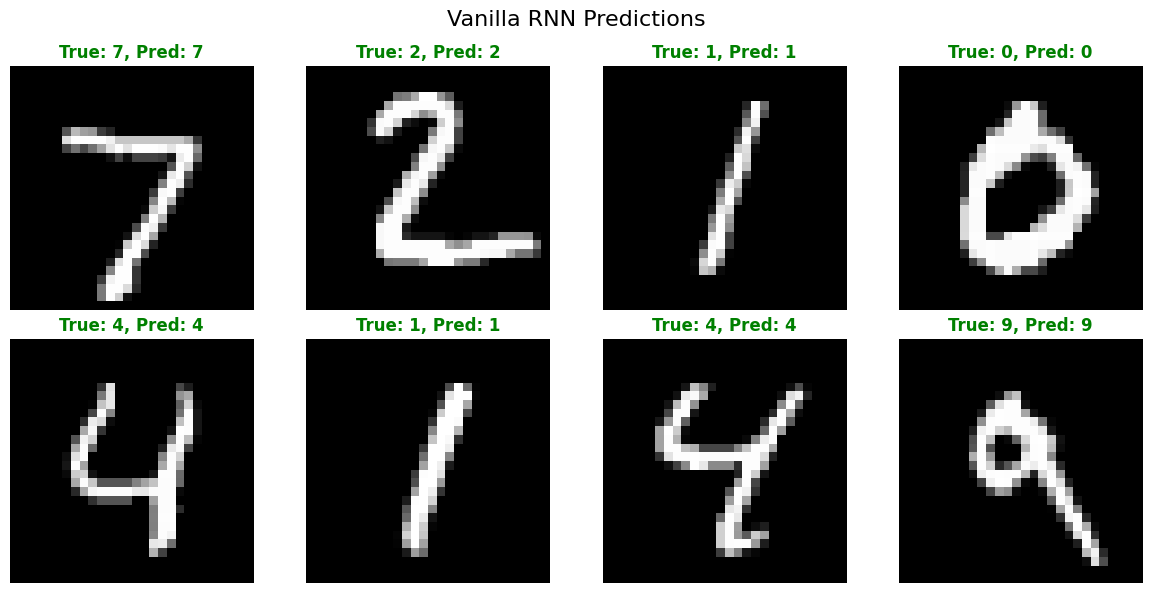

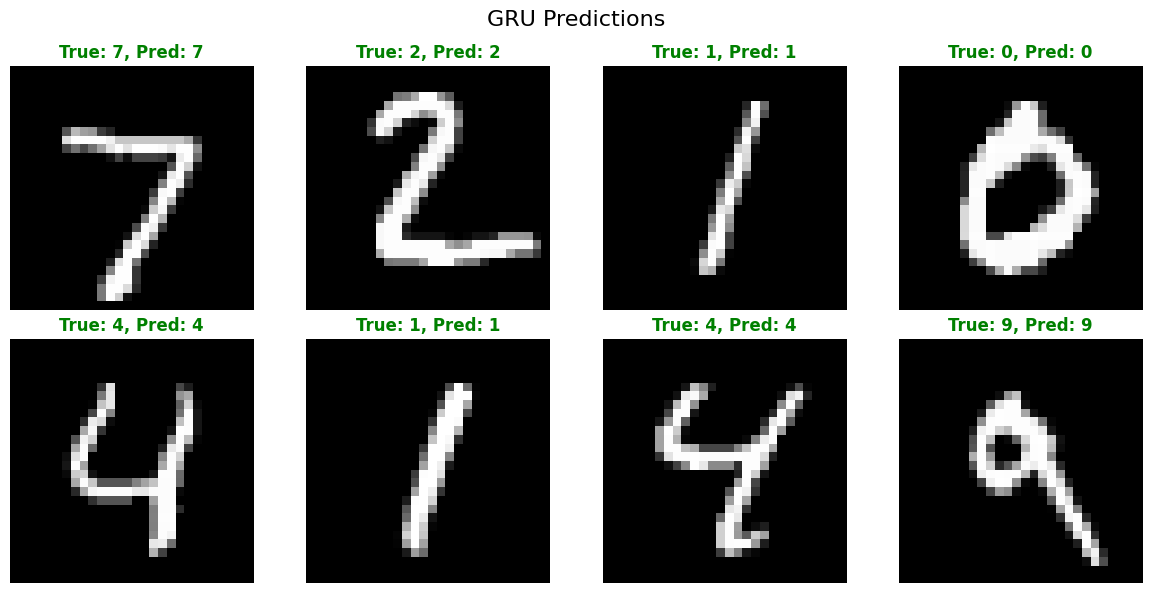

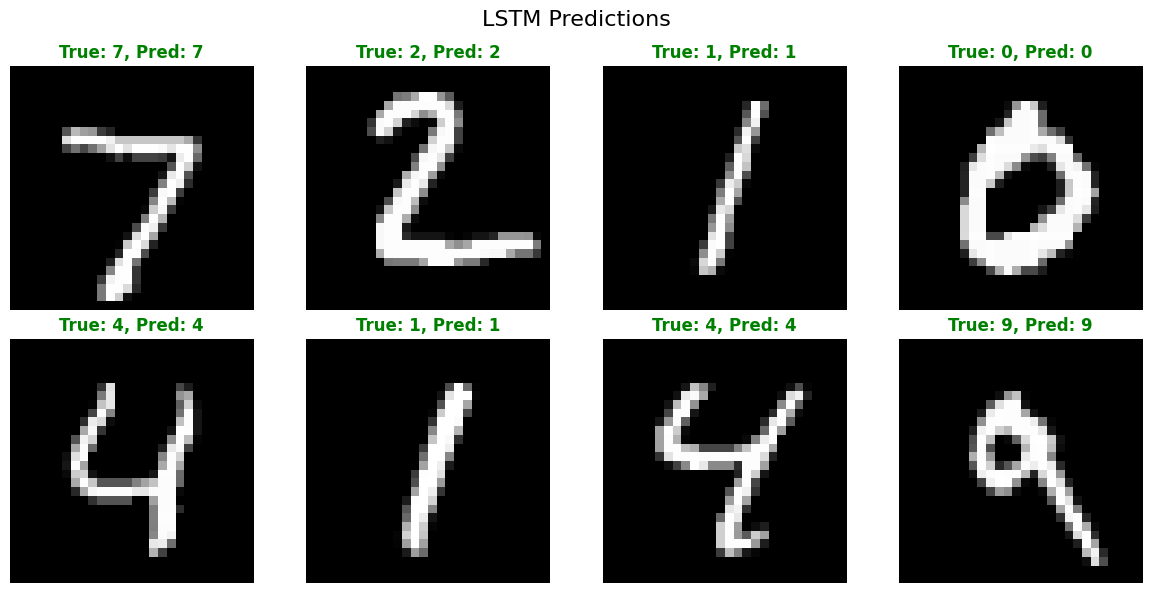

In [13]:
# Get some test samples for visualization
def visualize_predictions(model, model_name, num_samples=8):
    model.eval()
    
    # Get a batch of test data
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    # Select first few samples
    images = images[:num_samples]
    labels = labels[:num_samples]
    
    # Reshape for RNN
    images_rnn = images.reshape(-1, sequence_length, input_size).to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images_rnn)
        _, predicted = torch.max(outputs, 1)
    
    # Plot results
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle(f'{model_name} Predictions', fontsize=16)
    
    for i in range(num_samples):
        row = i // 4
        col = i % 4
        
        # Display image
        axes[row, col].imshow(images[i].squeeze(), cmap='gray')
        
        # Add prediction info
        true_label = labels[i].item()
        pred_label = predicted[i].item()
        
        color = 'green' if true_label == pred_label else 'red'
        axes[row, col].set_title(f'True: {true_label}, Pred: {pred_label}', 
                                color=color, fontweight='bold')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions for each model
visualize_predictions(rnn_model, "Vanilla RNN")
visualize_predictions(gru_model, "GRU")
visualize_predictions(lstm_model, "LSTM")

## 11. Key Takeaways and Summary

### Performance Summary:
- **LSTM**: Usually achieves highest accuracy due to sophisticated gating
- **GRU**: Good balance between performance and efficiency
- **Vanilla RNN**: Simplest but may struggle with longer sequences

### When to Use Each:

**Vanilla RNN:**
- Short sequences
- Simple patterns
- Limited computational resources
- Baseline comparisons

**GRU:**
- Medium-length sequences
- Faster training needed
- Good balance of performance/efficiency
- Speech recognition, machine translation

**LSTM:**
- Long sequences with complex dependencies
- Maximum performance needed
- Text generation, sentiment analysis
- Time series with long-term patterns

### Architecture Comparison:

| Aspect | Vanilla RNN | GRU | LSTM |
|--------|-------------|-----|------|
| **Gates** | None | 2 (Reset, Update) | 3 (Forget, Input, Output) |
| **Memory** | Hidden state only | Hidden state | Hidden + Cell state |
| **Parameters** | Fewest | Medium | Most |
| **Training Speed** | Fastest | Medium | Slowest |
| **Long-term Memory** | Poor | Good | Excellent |
| **Vanishing Gradients** | Severe | Mitigated | Well-solved |

### Real-world Applications:
- **Natural Language Processing**: Sentiment analysis, machine translation
- **Time Series**: Stock prediction, weather forecasting
- **Speech Recognition**: Converting audio to text
- **Video Analysis**: Action recognition, video captioning
- **Bioinformatics**: DNA sequence analysis, protein folding

## 12. Next Steps and Advanced Topics

### Improvements to Try:
1. **Bidirectional RNNs**: Process sequences in both directions
2. **Attention Mechanisms**: Focus on relevant parts of input
3. **Dropout**: Add regularization to prevent overfitting
4. **Layer Normalization**: Stabilize training
5. **Gradient Clipping**: Prevent exploding gradients

### Advanced Architectures:
- **Transformers**: Attention-based models (BERT, GPT)
- **Seq2Seq**: Encoder-decoder architectures
- **ConvLSTM**: Combining CNNs with LSTMs
- **Temporal Convolutional Networks**: CNN alternative to RNNs

### Optimization Tips:
- Use **teacher forcing** for sequence generation
- Implement **beam search** for better decoding
- Apply **curriculum learning** for complex tasks
- Use **mixed precision training** for efficiency

This notebook demonstrated the evolution from simple RNNs to sophisticated LSTM architectures, showing how gating mechanisms solve fundamental problems in sequential modeling. The concepts learned here form the foundation for understanding modern sequence models like Transformers!